In [1]:
import tensorflow as tf
#import os
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

**Note** : if you encounter an error running any of the examples below consider restarting the kernel and running this cell first

# DeepSIBA example 1 : Train ensemble
In this example a deepSIBA ensemble model will be trained from scratch using the model_params and train_params dictionaries

In [2]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 ,"ConGauss":True
}

The model_params dictionary contains the parameters to build the deepSIBA siamese GCN architecture, more specifically:
1. **max_atoms, num_atom_features, max_degree and num_bond_features** refer to the parameters needed to featurize the input chemical structures. For more information, refer to the *ESI of the deepSIBA publication*.
2. **graph_conv_width, conv1d_filters, conv1d_size, dropout_encoder** refer to the parameters of the siamese graph encoders.
3. **conv1d_filters_dist, conv1d_size_dist, dropout_dist, pool_size, dense_size, l2reg** refer to the parameters of the distance module.
4. **dist_thresh** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
5. **lr** is the learning rate.
6. **ConGauss** is by default set to False. **Set it True, only if training becomes difficult due to Loss becoming frequently Inf.** If set to True, a Gaussian Layer constrained to 0 to 1 is used instead of the original Gaussian layer.

In [3]:
train_params = {
    "cell_line" : "a375", "split" : "train_test_split", "number_folds" : [0],
    "output_dir" : "C:/Users/nmeim/Documents/deepSIBA_tf2/results",
    "batch_size" : int(128), "epochs" : int(13), 
    "N_ensemble" : int(50), "nmodel_start" : int(0), "prec_threshold" : 0.2,
    "Pre_training" : False,
    "Pre_trained_cell_dir" : 'C:/Users/nmeim/Documents/deepSIBA/learning/trained_models/a375/alldata/models/',
    "pattern_to_load" : 'siam_no_augment_',
    "model_id_to_load" : "20",
    "test_value_norm" : True,
    "predict_batch_size":int(2048),
    "RemedialEpochs" : int(3)
}

The train_params dictionary contains the parameters required to train deepSIBA:
1. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7,merged)** for which we have enough available data. The merged option refers to data merged across cell lines. Additional cellular moderls available, when pretrained models are used, are  **(npc,a549,ht29,hepg2,hcc519,hae1)** .
2. **split** is one of **(train_test_split,5_fold_cv_split,alldata)**. The data to train the models are available in our google drive folder, see **data/readme.md**.
3. **number_folds** is a list, if split == train_test_split the number_folds should be [0]. If the split is a 5_fold_cv_split the number_folds should be [0,1,2,3,4] in order to train the model in all splits. If you want to train a model on a specific fold, e.g. the 3rd one, the number_folds should be [2].
4. **output_dir** is the full path to the specified output directory.
5. **N_ensemble** is the number of models to train and include in the ensemble.
6. **nmodel_start** this should be set to 0 if training for the first time, but if training is halted, nmodel_start specifies the model number in the ensemble to start training from.
7. **prec_threshold** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
8. **Pre_training** indicates whether pre-trained weights will be load.
9. **Pre_trained_cell_dir** is the path of the directory that the pre-trained weights are located.
10. **pattern_to_load** is the filename pattern of the saved weights.
11. **model_id_to_load** is the number/id of the weights of one of the saved models from the ensemble training.
12. **test_value_norm** is the test/val value already normalized between 0-1.
13. **predict_batch_size** is the batch size with which predictions for the pairs of the validation set are made.
14. **RemedialEpochs** is extra epochs for training if r_suqare is less than 0.7.

In [ ]:
from deepSIBA_train import siba_trainer
example_1 = siba_trainer(train_params, model_params)

# DeepSIBA example 2 : Load trained ensemble and predict
In this example a trained deepSIBA ensemble model will be loaded and used to make predictions for the appropriate test set.
For each of the cell lines, trained ensembles of either 50 or 10 models for all available splits, can be found in our google drive, see **trained_models/readme.md**.

In [5]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 ,"ConGauss":True
}

First of all the model is compiled with the parameters (model_params) as described in example 1.

In [6]:
from deepSIBA_model import enc_graph, siamese_model, deepsiba_model
siamese_net = deepsiba_model(model_params)
print(siamese_net.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_inputs_1 (InputLayer)      [(None, 60, 62)]     0                                            
__________________________________________________________________________________________________
bond_inputs_1 (InputLayer)      [(None, 60, 5, 6)]   0                                            
__________________________________________________________________________________________________
edge_inputs_1 (InputLayer)      [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
atom_inputs_2 (InputLayer)      [(None, 60, 62)]     0                                            
____________________________________________________________________________________________

<img src="architecture.png">

In [7]:
test_params = {
    "cell_line" : "a375", "split" : "train_test_split", "fold_id" : int(0),
    "N_ensemble" : int(4), "prec_threshold" : 0.2,
    "name_pattern":"model",
    "test_value_norm" : True,
    "predict_batch_size":2048,
    "to_load": 1,
    "mu_path":'/home/biolab/Documents/Go distances/learning/models/Nick_ensembles_augm_pc3/cold/mu/',
    "sigma_path":'/home/biolab/Documents/Go distances/learning/models/Nick_ensembles_augm_pc3/cold/sigma/',
    "prediction_pattern":["cold_mu_No_","cold_sigma_No_"]
}

The test_params dictionary contains the parameters required to train deepSIBA:
1. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7)** for which we have enough available data. Later a merged option will be added.
2. **split** is one of **(train_test_split,5_fold_cv_split)**. 
3. **fold_id** is an integer, if split == train_test_split the fold_id should be 0. If the split is a 5_fold_cv_split the fold_id should be 0,1,2,3 or 4 (one less than the corresponding folder's name for this fold) in order to test the model's performance in **a specific split**.
4. **N_ensemble** is the number of total already trained models and at the same time the models included in the ensembled prediction.
5. **prec_threshold** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
6. **name_pattern** is the pattern of the name of files of models' saved weights. **For example** if the weights are saved in files with names such as **siam_no_augment_18.h5** the **pattern is siam_no_augment** .
7. **test_value_norm** is the test/val value already normalized between 0-1.
8. **predict_batch_size** is the batch size with which predictions for the pairs of the validation set are made.
9. **to_load** defines whether trained **models are loaded (1)** and predictions are made or if the **predictions of mean and sigma are loaded directly (give a random integer different from 1).**
10. **mu_path** is the path where the mean of distance predictions of each model are. If to_load=1 then its value doesn't matter.
11. **sigma_path** is the path where the standard deviation of distance predictions of each model are. If to_load=1 then its value doesn't matter.
12. **prediction_pattern** is a list with the pattern of the filenames of mean (mu) and sigma of each model. First is the mean and second the sigma. **THE PREDICTIONS MUST BE SAVED AS .npy files**. **For example** if the pattern is "cold_mu_" then the files are like "cold_mu_**x**.npy" where x is the model's number

**NOTE :** The saved model weights are in the subfolders of "trained_models/" and their exact position is described fully given **cell_line** and **split** parameters.


In [8]:
from deepSIBA_ensembles import siba_val_loader
df_cold=siba_val_loader(test_params, model_params,siamese_net)

Get the ensembled predictions with siba_val_loader function.
The data frame with the predictions and the corresponding CV (coefficient of variation) of each prediction is presented below

**NOTE:** All distance values have been adjusted in the range 0 to 1.

In [9]:
df_cold

X           Var1           Var2     value  \
0          91  BRD-A51714012  BRD-A54880345  0.156852   
1         104  BRD-A51714012  BRD-A62184259  0.327250   
2         118  BRD-A51714012  BRD-A83326220  0.318128   
3         133  BRD-A51714012  BRD-A93236127  0.315317   
4         149  BRD-A51714012  BRD-A93424738  0.179933   
...       ...            ...            ...       ...   
45579  224780  BRD-K48222931  BRD-K96041907  0.378380   
45580  224781  BRD-K62242359  BRD-K96041907  0.601630   
45581  224783  BRD-K88822846  BRD-K96041907  0.475502   
45582  224784  BRD-K89961851  BRD-K96041907  0.435324   
45583  224785  BRD-K92232855  BRD-K96041907  0.567322   

                                       sig_id.x   pert_iname.x  quality.x  \
0      CPC004_A375_6H:BRD-A51714012-001-03-1:10    venlafaxine          1   
1      CPC004_A375_6H:BRD-A51714012-001-03-1:10    venlafaxine          1   
2      CPC004_A375_6H:BRD-A51714012-001-03-1:10    venlafaxine          1   
3      CPC004_A375_6H:BRD-A51714012-001-03-1:10    venlafaxine          1   
4      CPC004_A375_6H:BRD-A51714012-001-03-1:10    venlafaxine          1   
...                                         ...            ...        ...   
45579  DOSBIO001_A375_24H:BRD-K48222931:10.2274  BRD-K48222931          1   
45580  DOSBIO001_A375_24H:BRD-K62242359:10.5421  BRD-K62242359          1   
45581  DOSBIO001_A375_24H:BRD-K88822846:10.1074  BRD-K88822846          1   
45582  DOSBIO001_A375_24H:BRD-K89961851:10.2368  BRD-K89961851          1   
45583  DOSBIO001_A375_24H:BRD-K92232855:10.1419  BRD-K92232855          1   

                                                 rdkit.x  pert_dose.x  \
0                       COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1      10.0000   
1                       COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1      10.0000   
2                       COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1      10.0000   
3                       COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1      10.0000   
4                       COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1      10.0000   
...                                                  ...          ...   
45579  C[C@@H](CO)N1C[C@@H](C)[C@H](CN(C)Cc2ccccc2)OC...      10.2274   
45580  CC(C)NC(=O)Nc1ccc2c(c1)C(=O)N([C@@H](C)CO)C[C@...      10.5421   
45581  C[C@@H]1CN([C@H](C)CO)C(=O)c2cc(NS(C)(=O)=O)cc...      10.1074   
45582  N#C[C@H]1[C@@H](c2ccc(C3=CCCCC3)cc2)[C@H](CO)N...      10.2368   
45583  CC(C)NC(=O)N(C)C[C@@H]1Oc2ccc(N(C)C)cc2CC(=O)N...      10.1419   

       pert_time.x  ... quality.y  \
0                6  ...         1   
1                6  ...         1   
2                6  ...         1   
3                6  ...         1   
4                6  ...         1   
...            ...  ...       ...   
45579           24  ...         1   
45580           24  ...         1   
45581           24  ...         1   
45582           24  ...         1   
45583           24  ...         1   

                                                 rdkit.y  pert_dose.y  \
0                            CCOC(=O)c1cncn1C(C)c1ccccc1      10.0000   
1                CC1CC(C)C(=O)C(C(O)CC2CC(=O)NC(=O)C2)C1      10.0000   
2                  Oc1ccc2c(c1)OCC1(O)Cc3cc(O)c(O)cc3C21      10.0000   
3      C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...      10.0000   
4      CC(=O)OCC(=O)[C@@]1(O)[C@H](C)CC2C3CCC4=CC(=O)...      10.0000   
...                                                  ...          ...   
45579  CCCNC(=O)N(C)C[C@H]1N[C@@H](CO)[C@@H]1c1ccc(C2...      10.2154   
45580  CCCNC(=O)N(C)C[C@H]1N[C@@H](CO)[C@@H]1c1ccc(C2...      10.2154   
45581  CCCNC(=O)N(C)C[C@H]1N[C@@H](CO)[C@@H]1c1ccc(C2...      10.2154   
45582  CCCNC(=O)N(C)C[C@H]1N[C@@H](CO)[C@@H]1c1ccc(C2...      10.2154   
45583  CCCNC(=O)N(C)C[C@H]1N[C@@H](CO)[C@@H]1c1ccc(C2...      10.2154   

      pert_time.y        V1  sigma_star      dist  \
0               6  0.323492    0.046807  0.841270   
1               6  0.299491    0.045602  0.888889   
2               6  0.243868    0.049710  0.8

Finally the model's performance together with a scatterplot of the predicted values VS the true values of the test set, are given bellow:

**NOTE:** If there are no predictions lower than the precision threshold defined, the MSE in the predictions lower than the defined threshold and the precision will be **None**

       cor  mse_all  mse_similars  precision  accuracy       FPR  positives
0  0.59236  0.00819      0.005188   0.930147  0.835798  0.000502        272


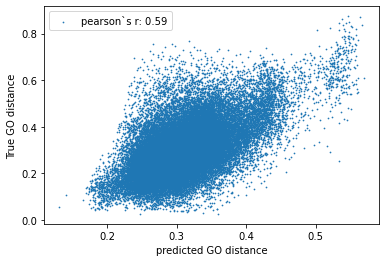

In [10]:
from utility.evaluator import model_evaluate
import numpy as np
from matplotlib import pyplot as plt
true = np.array(df_cold.value)
pred = np.array(df_cold.mu)
get_eval=model_evaluate(pred,true,test_params["prec_threshold"],df_cold)
print(get_eval)
plt.scatter(pred,true,s = 0.5, label = "pearson`s r: "+str(round(get_eval['cor'][0],2)))
plt.xlabel("predicted GO distance")
plt.ylabel("True GO distance")
plt.legend(loc='upper left')
plt.show()

# DeepSIBA example 3 : Screening

In this example a trained deepSIBA ensemble model will be used to identify chemical structures from the Chembl and the CMap datasets that affect similar biological processes to a query structure. 
Given a **query chemical structure and a cellular model**:

1. If a structural analogue to the query (ECFP4 similarity > 0.9) is present in the cell line's training set, the **CMap** and the **Chembl** datasets will be screened for chemical structures that affect similar BPs to the query.
2. If no structural analogue exists, the appropriate training set from the **CMap** dataset will be screened.

**NOTE** : Our trained deepSIBA ensembles allow query structures of up to 60 atoms. 

In [2]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 ,"ConGauss":False
}

In [3]:
screening_params = {
    "query_smile" : "NS(=O)(=O)c1ccc(NC2=CC(=O)c3ccccc3C2=O)cc1", 
    "cell_line" : "a375", "split" : "train_test_split" ,"database" : ["Chembl"],
    "output_dir" : "../results/screening_test6" , "model_path" : "", 
    "atom_limit" : int(60), "N_models" : int(10),
    "name_pattern" : "model", "fold_id" : int(0),
    "screening_threshold" : 0.28
}

The screening_params dictionary contains the parameters required to screen a database with deepSIBA:

1. **query_smile** is the smile string of the chemical structure.
2. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7)** for which we have enough available data. Later a merged option will be added.
3. **split** is one of **(train_test_split,5_fold_cv_split,alldata,custom)**. The split selected defines the trained model ensemble that will be loaded. For the screening application the **alldata** split is suggested, where models are trained on the entirety of available data. If **custom** is selected the user must provide a path in **model_path** to load the custom trained models (up to models/ directory).
3. **database** is a list of the supported screening databases. So far only **Chembl** and **CMap** are supported.
4. **output_dir** full path to the desired output directory to write results. The Chembl screening is performed in parts due to the size of the database.
5. **atom_limit** the specified model_params of the trained models, when the split is not **custom** these should be 60.
6. **N_ensemble** is the number of total already trained models and at the same time the models included in the ensembled prediction.
7. **name_pattern** is the pattern of the name of files of models' saved weights. **For example** if the weights are saved in files with names such as **siam_no_augment_18.h5** the **pattern is siam_no_augment** .
8. **fold_id** is an integer, if split == 5_fold_cv_split the fold_id should be 0,1,2,3 or 4 (one less than the corresponding folder's name for this fold), in any other cases the fold_id is not used
9. **screening_threshold** only keep hits with predicted distance less than this threshold in the results.

In [4]:
from deepSIBA_screening2 import siba_screening
siba_screening(screening_params, model_params)

Using TensorFlow backend.


Screening chembl


W1015 14:16:20.418790 140254271780672 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 14:16:20.423854 140254271780672 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 14:16:20.424507 140254271780672 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1015 14:16:20.533672 140254271780672 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defau

Finished screening for part 1/9 for the Chembl database
Finished screening for part 2/9 for the Chembl database
Finished screening for part 3/9 for the Chembl database
Finished screening for part 4/9 for the Chembl database
Finished screening for part 5/9 for the Chembl database
Finished screening for part 6/9 for the Chembl database
Finished screening for part 7/9 for the Chembl database
Finished screening for part 8/9 for the Chembl database
Finished screening for part 9/9 for the Chembl database
